In [2]:
import importlib
from typing import Dict, Tuple
from matplotlib import pyplot as plt
from shared.definitions import TuningResult
# from shared.ml_config_core import ModelTrainingResult
from shared import stats_utils
from shared.ml_config_runner import build_production_model_for_tuning_result
from shared import graph
from shared import utils
import seaborn as sns
import pandas as pd
import xgboost
from Draft import feature_builder_v2
import importlib
import xgboost as xgb
import shared.ml_config_core as ml_config_core

# import matplotlib.pyplot as plt
VERBOSE = False
utils.pandas_config(pd)
utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")

#### Selecting Best Performing Model




In [4]:
model_results_df = pd.read_csv("data/results_all_models_test.csv")

#TODO: add size in mb and training time
utils.create_styled_df(model_results_df, 1, decimals=2)

,Model,auc,pr_auc,_f1_micro,_f1_macro,logloss,accuracy,precision_macro,recall_macro,f1_macro,target_f1,target_recall,target_precision,fbeta_1.5,fbeta_2.5,fbeta_4.0,log_loss,elapsed_time,total_size
0,LGBM_Dart_AUC,0.79,0.28,0.73,0.56,9.75,0.73,0.58,0.72,0.56,0.30,0.71,0.19,0.38,0.51,0.61,0.54,131.20,21.83
1,LGBM_AUC,0.79,0.28,0.74,0.57,9.54,0.74,0.58,0.72,0.57,0.30,0.69,0.19,0.38,0.51,0.60,0.53,53.00,23.59
2,LGBM_AUC_All_Features,0.79,0.28,0.74,0.57,9.42,0.74,0.58,0.71,0.57,0.30,0.68,0.19,0.38,0.50,0.59,0.53,46.70,39.72
3,LGBM_AUC_Base_Features,0.77,0.25,0.71,0.55,10.33,0.71,0.57,0.70,0.55,0.28,0.67,0.17,0.36,0.48,0.57,0.56,17.10,21.20
4,LGBM_Weighted_LogLoss,0.76,0.24,0.73,0.56,9.61,0.73,0.57,0.69,0.56,0.28,0.64,0.18,0.36,0.47,0.56,0.54,12.60,11.85
5,Baseline_Only_CreditRatings,0.73,0.20,0.67,0.52,11.77,0.67,0.56,0.67,0.52,0.25,0.66,0.15,0.32,0.45,0.55,0.61,3.40,2.21


In [18]:
importlib.reload(ml_config_core)

SELECTED_MODEL_ALT_KEY = "LGBM_Dart_AUC"
SELECTED_MODEL_KEY = "LGBM_AUC"
BASELINE_MODEL_KEY = "Baseline_Only_CreditRatings"

selected_model: ml_config_core.ModelTrainingResult = ml_config_core.ModelTrainingResult.load_serialize_model(
    SELECTED_MODEL_KEY)

selected_model_alt: TuningResult = ml_config_core.ModelTrainingResult.load_serialize_model(
    SELECTED_MODEL_ALT_KEY)

selected_model_pipeline_info: TuningResult = TuningResult.load_serialized_tuning_result(
    SELECTED_MODEL_KEY)

baseline_model: ml_config_core.ModelTrainingResult = ml_config_core.ModelTrainingResult.load_serialize_model(
    BASELINE_MODEL_KEY)

results_all_models = {
    SELECTED_MODEL_KEY: selected_model,
    SELECTED_MODEL_ALT_KEY: selected_model_alt,
    BASELINE_MODEL_KEY: baseline_model
}

V:\projects\ppuodz-ML.4.1\shared\graph.py:1056: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


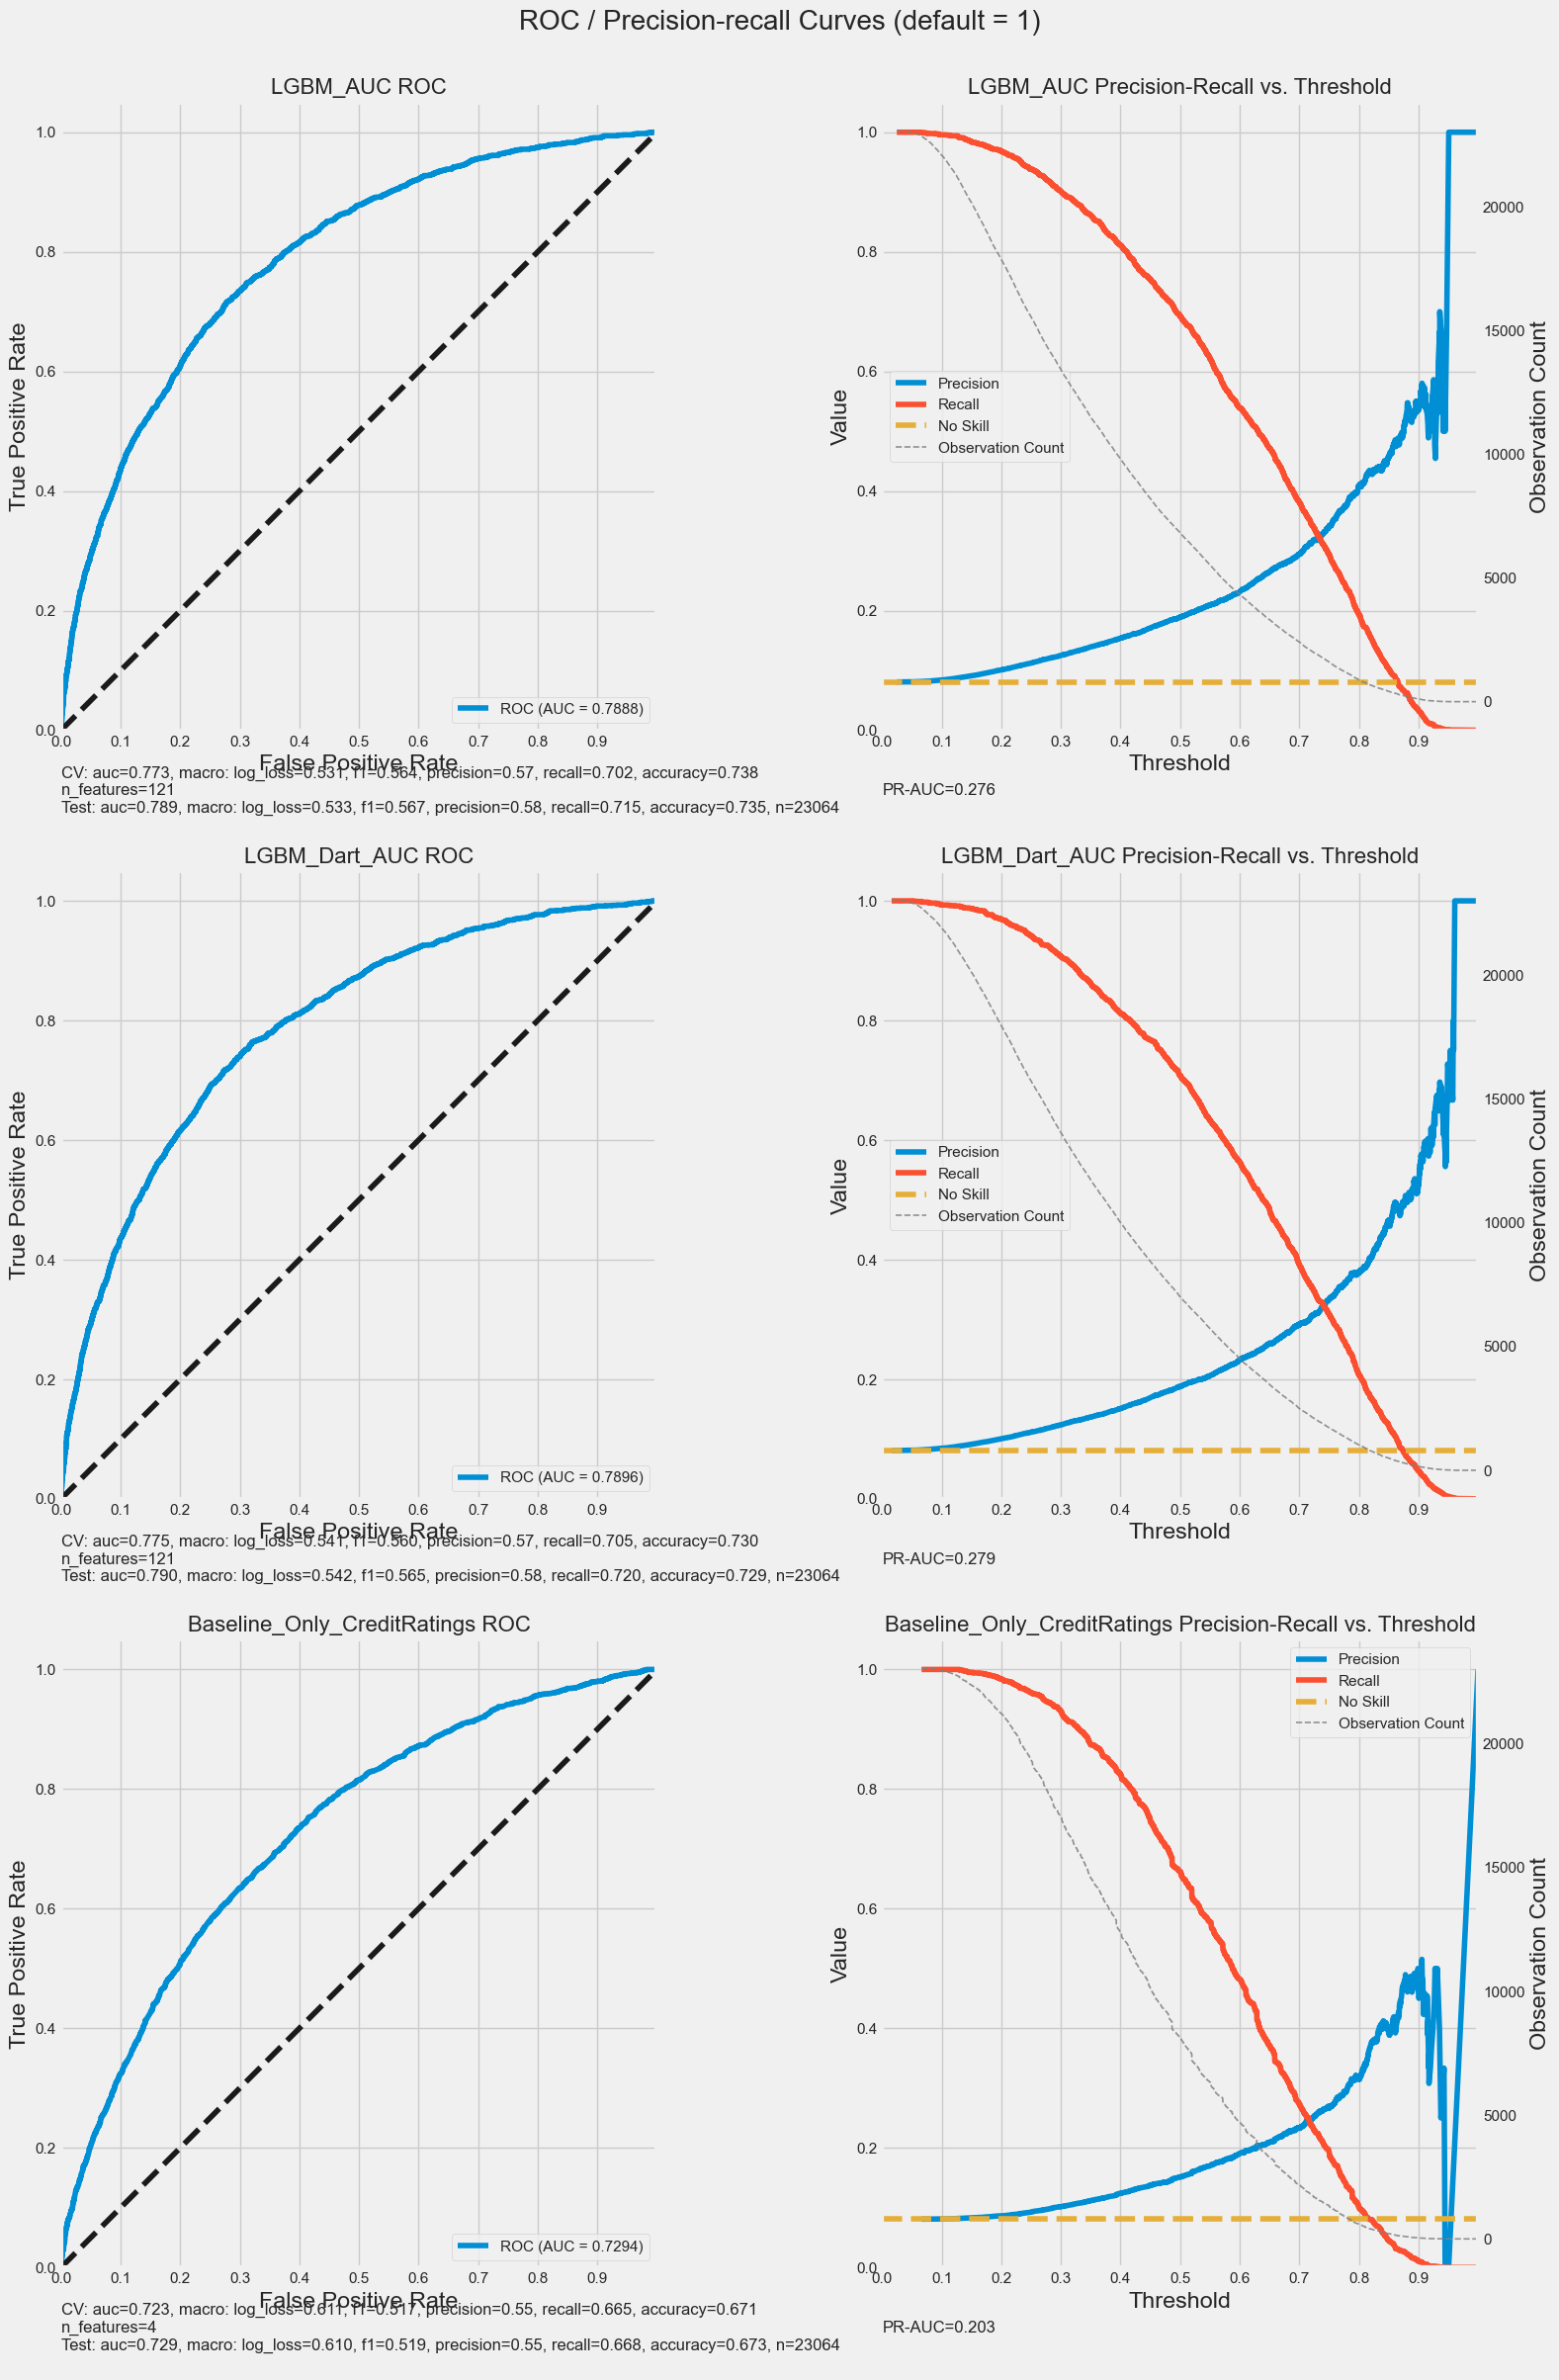

In [20]:
importlib.reload(graph)

graph.roc_precision_recal_grid_plot(results_all_models, show_observation_count=True)

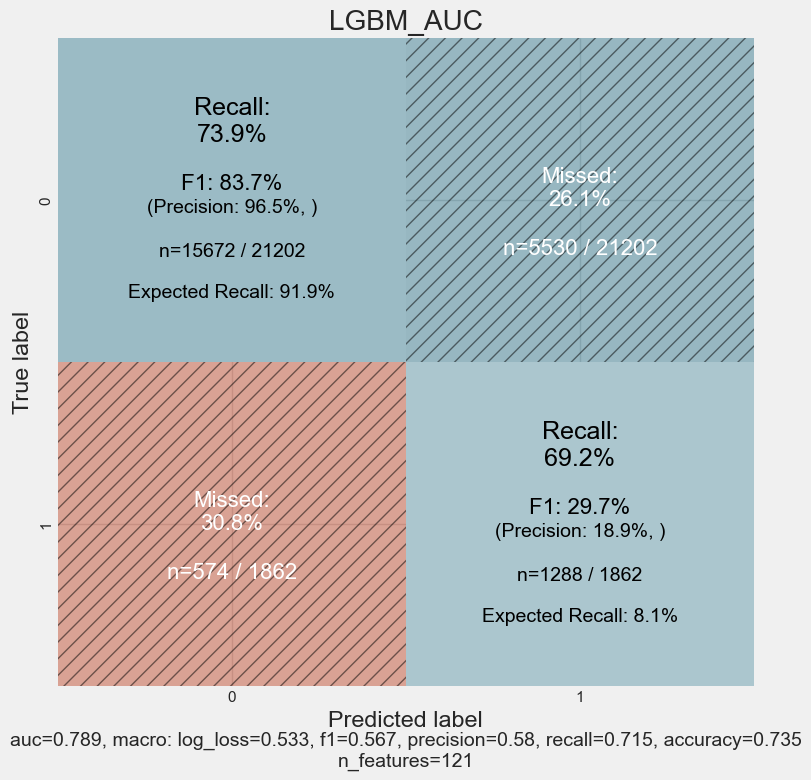

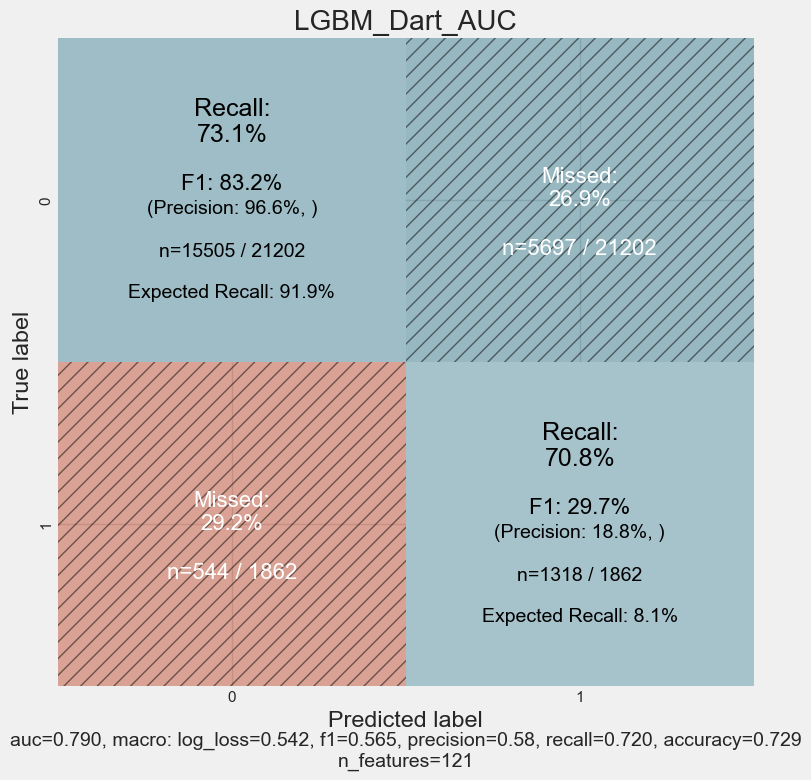

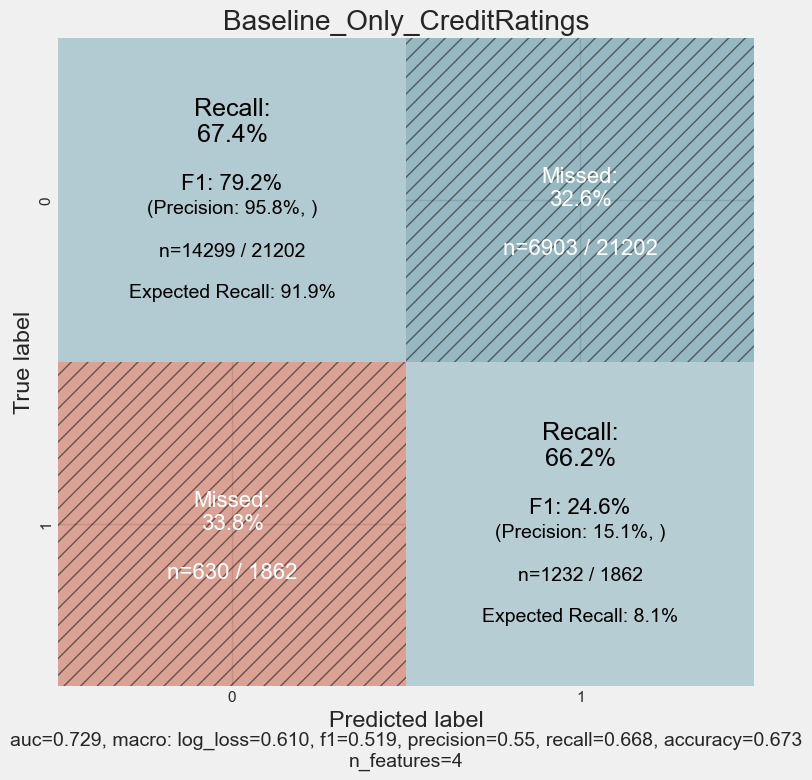

In [25]:
importlib.reload(graph)


for model_key, selected_model in results_all_models.items():
    graph.confusion_matrix_plot_v2(
        selected_model.cm_data,
        title=model_key,
        annotations=graph.make_annotations(selected_model.test_data.metrics_2,
                                           n_feats=len(selected_model.cm_data.x_test.columns)),
    )

plt.show()

In [15]:
from shared import pipeline

features_matrix = selected_model_pipeline_info.model_pipeline_config.load_data(
    loader_function=feature_builder_v2.load_datasets_and_prepare_features)
# 
features_all, labels_all = pipeline._get_features_labels(features_matrix)
X_train, X_test, y_train, y_test = pipeline.get_deterministic_train_test_split(
    features_all, labels_all
)

X_train = X_train.drop(columns=["TARGET"])
X_test = X_test.drop(columns=["TARGET"])

C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
 

Appending previous history
drop drop_cols_post_proc: 227
after drop_cols_post_proc: 121
Full DS size: 307511


In [16]:
model = selected_model.test_data.test_model.named_steps["model"]
prob_pos = model.predict_proba(X_test)[:, 1]


C:\Users\Paulius\AppData\Local\pypoetry\Cache\virtualenvs\ppuodz-ml-4-1-dqELbViF-py3.12\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


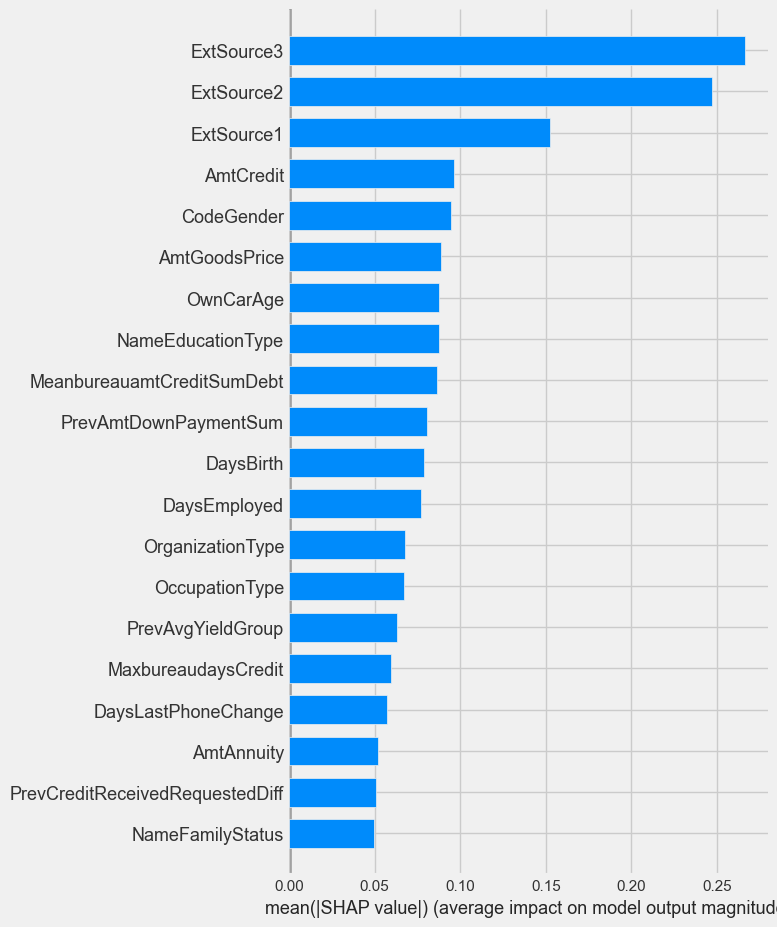

In [17]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


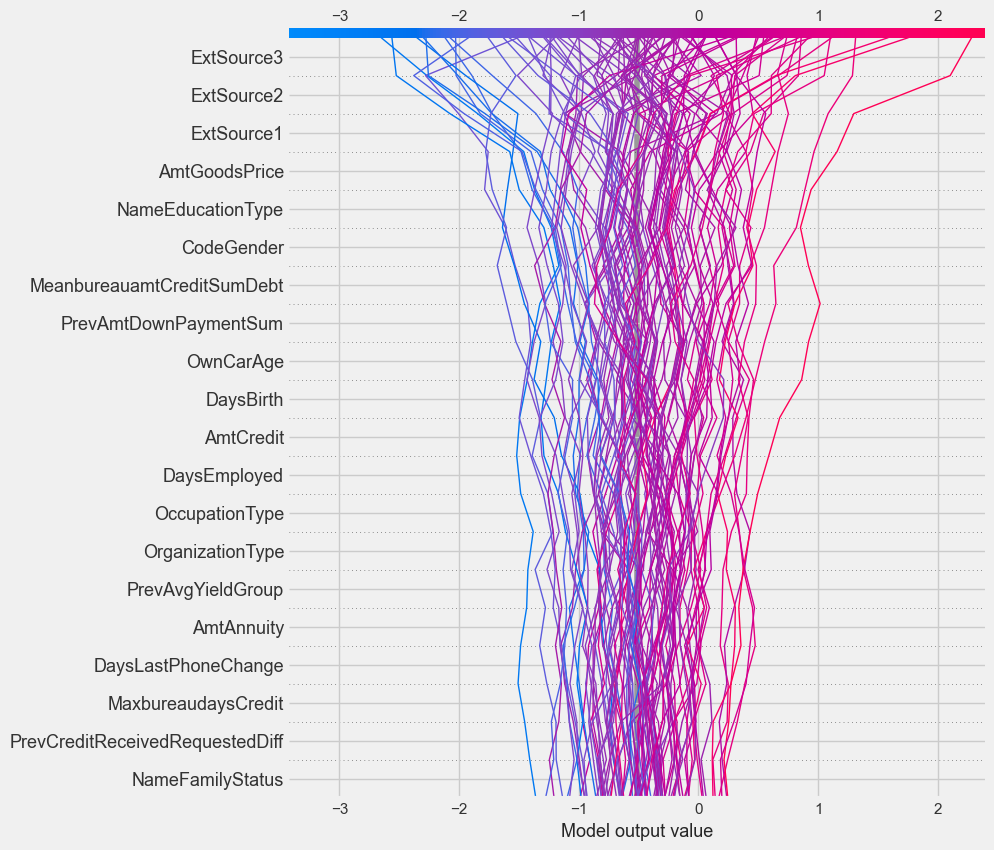

In [18]:

# Number of samples to include in subsample
num_samples = 100

# Generate random indices for subsampling
indices = np.random.choice(X_test.shape[0], num_samples, replace=False)

# Subsample the SHAP values and test data
shap_values_subsample = shap_values[indices]
X_test_subsample = X_test.iloc[indices]

# Use the subsampled data in the decision plot
shap.decision_plot(explainer.expected_value, shap_values_subsample, X_test_subsample, ignore_warnings=True)







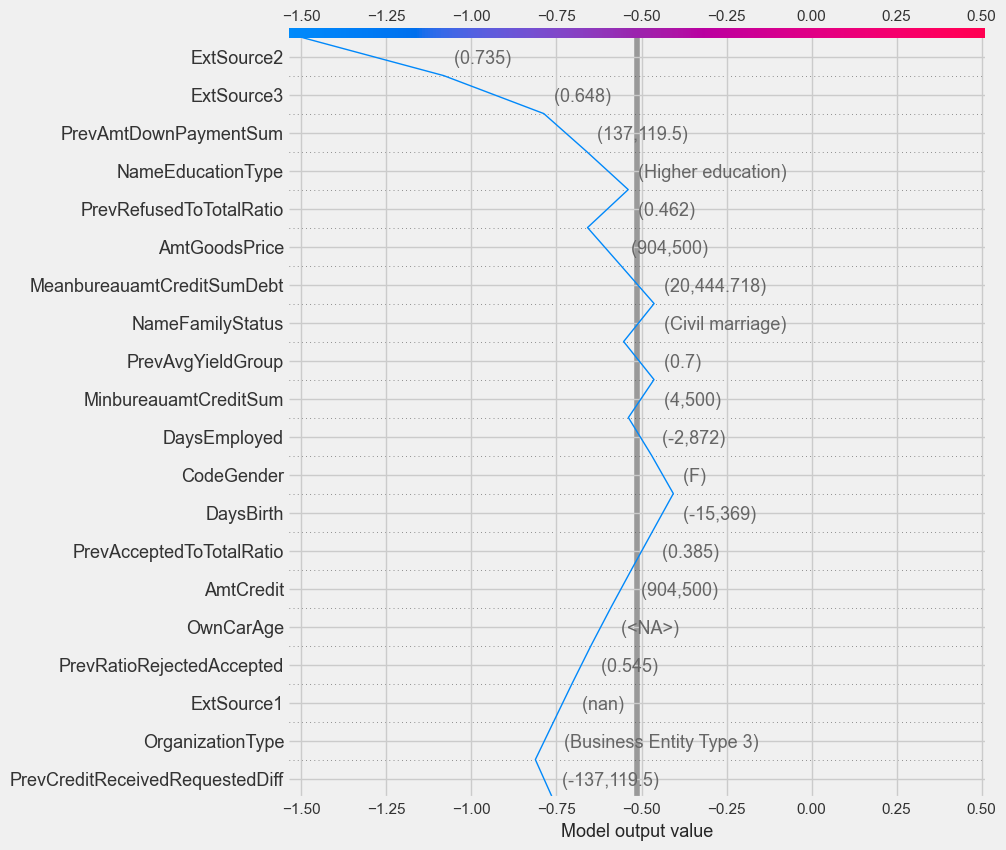

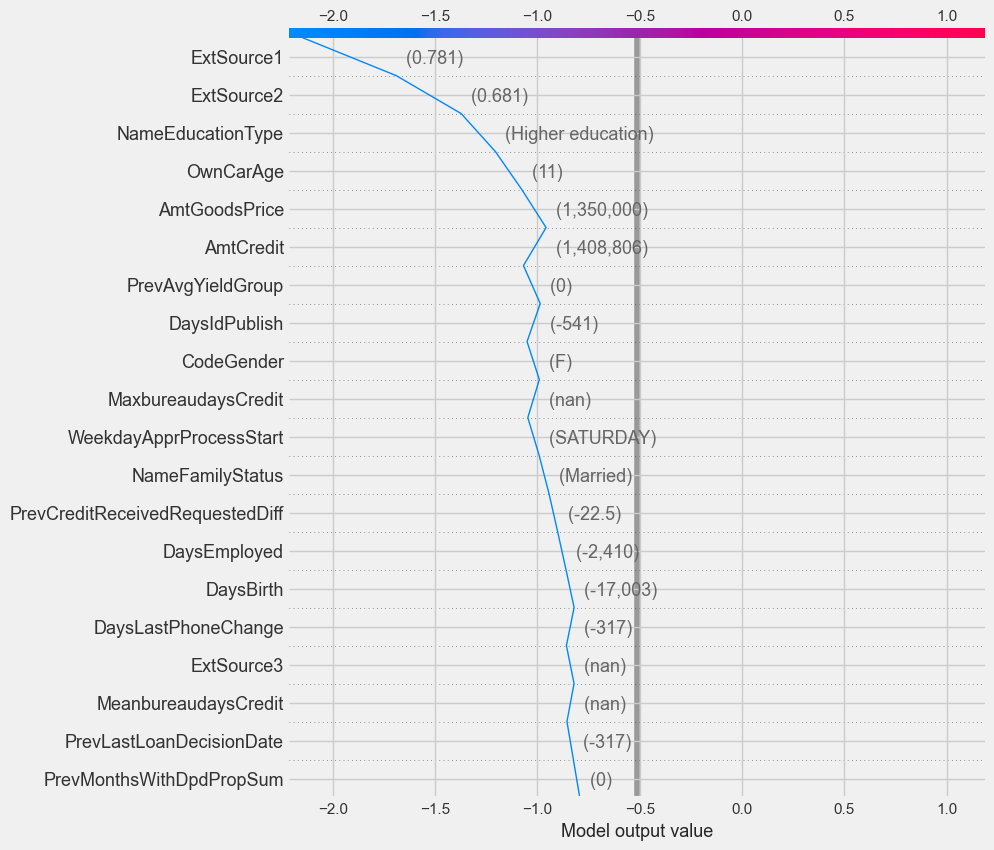

In [19]:
import numpy as np

# Number of samples to include in subsample
num_samples = 100

# Generate random indices for subsampling from the full dataset
indices = np.random.choice(X_test.shape[0], num_samples, replace=False)

# Subsample the SHAP values and test data
shap_values_subsample = shap_values[indices]
X_test_subsample = X_test.iloc[indices]

# Indices of specific observations to display with feature values
specific_indices = [0, 1]  # Adjust indices based on your needs within the subsample

# Plot each specific index with feature values
for idx in specific_indices:
    shap.decision_plot(
        explainer.expected_value,
        shap_values_subsample[idx],
        features=X_test_subsample.iloc[idx],
        feature_names=X_test.columns.tolist(),
        ignore_warnings=True
    )


Each plotted line explains a single model prediction.

In [20]:
# Note that we are slicing off the column of the shap_values Explanation corresponding to the "Age" feature
shap.plots.scatter(shap_values[:, "ExtSource2"])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
import numpy as np

# Calculate absolute differences between predicted probabilities and actual values
predicted_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

absolute_differences = np.abs(predicted_probabilities - y_test)
real_differences = predicted_probabilities - y_test

# Create a DataFrame for easier handling
differences_df = pd.DataFrame({
    "y_test": y_test,
    "predicted_probabilities": predicted_probabilities,
    'real_differences': real_differences,
    'absolute_difference': absolute_differences,
    'index': range(len(y_test))
})

# Sort by 'absolute_difference' in descending order and select the top N
N = 4
top_differences_df = differences_df.nlargest(N, 'absolute_difference')
min_differences_df = differences_df.nsmallest(N, 'absolute_difference')

min_diff_only_default = differences_df[differences_df['y_test'] == 1].nsmallest(N, 'absolute_difference')
# posmin = differences_df.nsmallest(N, 'real_differences')

# If you want a random sample of N from these top differences
random_sample_top_diff = top_differences_df.sample(n=N, random_state=42)  # Use a fixed seed for reproducibility
random_sample_min_diff = min_differences_df.sample(n=N, random_state=42)  # Use a fixed seed for reproducibility
random_sample_posmin_diff = min_diff_only_default.sample(n=N, random_state=42)  # Use a fixed seed for reproducibility

# Get the indices of the selected samples
selected_indices = random_sample_top_diff['index'].values
selected_min_indices = random_sample_min_diff['index'].values
posmin_indices = random_sample_posmin_diff['index'].values

# Use these indices to select instances from X_test or y_test if needed
# selected_samples_X_test = X_test.iloc[selected_indices]
# selected_samples_y_test = y_test.iloc[selected_indices]


import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` and `X_test` are already defined
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Select 10 random samples from X_test
# np.random.seed(42)  # For reproducibility
# random_indices = np.random.choice(X_test.shape[0], min(10, X_test.shape[0]), replace=False)

# Plot waterfall plots for the selected samples
# for index in posmin_indices:
for index in np.concatenate([posmin_indices, selected_min_indices, selected_indices]):
    # Create an Explanation object from SHAP values
    shap_explanation = shap.Explanation(values=shap_values[index],
                                        base_values=explainer.expected_value,
                                        data=X_test.iloc[index, :],
                                        feature_names=X_test.columns.tolist())

    # Plotting the waterfall plot
    shap.plots.waterfall(shap_explanation, max_display=7, show=False)

    predicted_probability = model.predict_proba(X_test.iloc[index:index + 1])[0, 1]
    actual_y_value = y_test.iloc[index]

    plt.title(f"{index}, Actual Y Value: {actual_y_value}, Predicted Probability: {predicted_probability:.2f}")
    plt.show()



In [ ]:
print(2)

In [ ]:
import numpy as np

# Assuming shap_values is a list of SHAP values for a multi-class model, or a numpy array for a binary model
if isinstance(shap_values, list):  # Multi-class scenario
    # Calculate the mean absolute SHAP values for each feature across all classes
    shap_abs_mean = np.abs(np.concatenate(shap_values, axis=0)).mean(axis=0)
else:  # Binary classification or regression
    shap_abs_mean = np.abs(shap_values).mean(axis=0)

# Creating a DataFrame with feature names and their corresponding mean absolute SHAP values
feature_importances_df = pd.DataFrame(list(zip(X_test.columns, shap_abs_mean)),
                                      columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Display the DataFrame
# display(feature_importances_df)

low_imp = feature_importances_df[feature_importances_df["Importance"] < 0.002]

In [ ]:
import numpy as np

# Calculate absolute differences between predicted probabilities and actual values
predicted_probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

absolute_differences = np.abs(predicted_probabilities - y_test)

# Create a DataFrame for easier handling
differences_df = pd.DataFrame({
    'absolute_difference': absolute_differences,
    'index': range(len(y_test))
})

# Sort by 'absolute_difference' in descending order and select the top N
N = 10
top_differences_df = differences_df.nlargest(N, 'absolute_difference')

# If you want a random sample of N from these top differences
random_sample_top_diff = top_differences_df.sample(n=N, random_state=42)  # Use a fixed seed for reproducibility

# Get the indices of the selected samples
selected_indices = random_sample_top_diff['index'].values

# Use these indices to select instances from X_test or y_test if needed
selected_samples_X_test = X_test.iloc[selected_indices]
selected_samples_y_test = y_test.iloc[selected_indices]


In [ ]:
target_cm_data = selected_model.test_data
target_cm_data_sorted = target_cm_data.probabilities.sort_values(by=1).reset_index(
    drop=True
)
prediction_data = target_cm_data.probabilities.copy()
prediction_data["value"] = target_cm_data.y_test

In [ ]:
# Assuming source_df_grades_summary and target_cm_data are already defined
# Sort probabilities for cumulative proportion mapping

# Define the data as a dictionary
data = {
    "index": ["A", "B", "C", "D", "E", "F", "G"],
    "Proportion": [0.12, 0.14, 0.17, 0.14286, 0.14286, 0.14286, 0.14286],
    "Loan_Status_Ratio": [1, 1, 1, 1, 1, 1, 1]
}

# Convert the dictionary to a DataFrame
source_df_grades_summary = pd.DataFrame(data)

# Set the 'index' column as the index of the DataFrame
source_df_grades_summary = source_df_grades_summary.set_index('index')

source_df_grades_summary["Cumulative"] = source_df_grades_summary["Proportion"].cumsum()
source_df_grades_summary["Cumulative"] = source_df_grades_summary["Cumulative"].clip(
    upper=1
)

sections = []

palette = sns.color_palette("YlOrRd", n_colors=len(source_df_grades_summary))

start_color = "grey"
colors = (
        [start_color] + palette + ["red"]
)  # Ensure "red" is used for the merged EFG section

i = 0
previous_cumulative = 0

# efg_weights = source_df_grades_summary.loc["E":"G", "Counts"]
# efg_risks = source_df_grades_summary.loc["E":"G", "Loan_Status_Ratio"]
# weighted_avg_risk_efg = np.average(efg_risks, weights=efg_weights)

# Find thresholds in target_cm_data that match cumulative proportions
for grade, row in source_df_grades_summary.iterrows():
    if grade == source_df_grades_summary.index[0]:
        start = 0.0
    else:
        start = target_cm_data_sorted[1].quantile(previous_cumulative)

    end = target_cm_data_sorted[1].quantile(row["Cumulative"])

    #  merge grades E, F, G
    # if grade == "E":
    #     continue
    # elif grade == "F":
    #     continue
    # elif grade == "G":
    #     label = "E-F-G Grade"
    #     color = "red"
    # else:
    if True:
        label = f"{grade} Grade"
        color = colors[i]

    # if grade == "G":
    #     description = f"Expected D. R.: {weighted_avg_risk_efg:.1%}"
    # else:
    #     description = f"Expected D. R.: {row['Loan_Status_Ratio']:.1%}"

    sections.append(
        {
            "label": label,
            "start": start,
            "end": end,
            "color": color,
            "description": "",
        }
    )
    if grade != "G":
        i += 1
    previous_cumulative = row["Cumulative"]
sections[-1]["end"] = 1.35
# sections




In [ ]:
import numpy as np
import pandas as pd


# def calculate_thresholds(prediction_data: pd.DataFrame) -> list:
#     # Default rates dictionary included within the function
#     default_rates = {'A': 0.01, 
#                      'B': 0.03, 
#                      'C': 0.07,
#                      'D': 0.15, 
#                      'E-F-G': 1}
#                      # 'E': 0.25,
#                      # 'F': 0.35, 
#                      # 'G': 1.0}
#     
#     palette = sns.color_palette("YlOrRd", n_colors=len(default_rates))
#     
#     start_color = "grey"
#     colors = (
#         [start_color] + palette + ["red"]
#     )  # Ensure "red" is used for the merged EFG section
# 
#     # Prepare the data
#     prediction_data_sorted = prediction_data.sort_values(by=1, ascending=True)
#     prediction_data_sorted['cumulative_default'] = prediction_data_sorted['value'].cumsum()
#     prediction_data_sorted['cumulative_non_default'] = np.arange(1, len(prediction_data_sorted) + 1) - prediction_data_sorted['cumulative_default']
#     prediction_data_sorted['default_rate'] = prediction_data_sorted['cumulative_default'] / (prediction_data_sorted['cumulative_non_default'] + prediction_data_sorted['cumulative_default'])
# 
#     # Initialize the list to store sections
#     sections = []
#     start = 0.0  # Initial start value
#     
#     i = 0
#     for grade, rate in default_rates.items():
#         # Identify the threshold for the current grade
#         mask = prediction_data_sorted['default_rate'] <= rate
#         if mask.any():
#             max_prob = prediction_data_sorted.loc[mask, 1].max()
#             end = max_prob
#         else:
#             end = 1.0
#         
#         
#         
#         # Append the section
#         sections.append({
#             "label": f"{grade} Grade",
#             "start": start,
#             "end": end,
#             "color": colors[i],
#             "description": f"Default rate up to {rate:.1%}"
#         })
#         
#         i+=1
#         start = end  # Update start for the next grade
#     
#     # Ensure the last section end is set correctly
#     if sections:
#         sections[-1]['end'] = 1.0
#     
#     return sections
# 
# # Assuming prediction_data is defined
# Example usage 
def calculate_thresholds(prediction_data: pd.DataFrame) -> list:
    # Default rates dictionary is now internal to the function
    default_rates = {'A': 0.01, 'B': 0.03, 'C': 0.07, 'D': 0.15, 'E-F-G': 1.0}
    # default_rates = {'A': 0.01, 'B': 0.03, 'C': 0.07, 'D': 0.15, 'E': 0.25, 'F': 0.35, 'G': 1.0}

    # Adjust the color palette as specified
    palette = sns.color_palette("YlOrRd", n_colors=len(default_rates) - 2)
    start_color = "grey"
    colors = [start_color] + palette + ["red"]

    # Sort by predicted probability of default
    prediction_data_sorted = prediction_data.sort_values(by=1, ascending=True)

    sections = []
    previous_threshold = 0.0
    color_index = 0

    for grade, max_default_rate in default_rates.items():
        # Filter data for loans not yet assigned to a more secure grade
        remaining_loans = prediction_data_sorted[prediction_data_sorted[1] > previous_threshold]

        # Calculate cumulative defaults and loans for remaining loans
        remaining_loans['cumulative_defaults'] = remaining_loans['value'].cumsum()
        total_loans = np.arange(1, len(remaining_loans) + 1)
        remaining_loans['default_rate'] = remaining_loans['cumulative_defaults'] / total_loans

        # Find the threshold where the default rate exceeds the grade's max default rate
        valid_loans = remaining_loans[remaining_loans['default_rate'] <= max_default_rate]
        if not valid_loans.empty:
            threshold = valid_loans[1].max()
        else:
            # If no loans meet the criteria, the threshold is the previous threshold
            threshold = previous_threshold

        # Append section with calculated thresholds and color
        sections.append({
            "label": f"{grade} Grade",
            "start": previous_threshold,
            "end": threshold,
            "color": colors[color_index],
            "description": f"Default rate up to {max_default_rate * 100:.0f}%"
        })

        # Update for the next iteration
        previous_threshold = threshold
        color_index += 1

    # Ensure the last section goes up to 1
    if sections:
        sections[-1]['end'] = 1.0

    return sections


sections = calculate_thresholds(prediction_data)
print(sections)
importlib.reload(stats_utils)
importlib.reload(graph)
summary_desc = "`The chart shows the  performance of the if only individual with stroke Prob. > T are selected. Additionally the overlay indicates the number of people whose predicted P is in an given range. The overlays can be used to selected the most at risk individual based on the probability predicted for them`"
from IPython.core.display import Markdown

graph.plot_threshold_metrics_v2(
    target_cm_data,
    0,
    1,
    sections=sections,
    model_name=SELECTED_MODEL_KEY,
    class_pos=1,
    include_vars=["f1", "precision", "recall"],
    show_threshold_n=True,
    log_x=False,
)
display(Markdown(summary_desc))

In [ ]:
TARGET_RETURN = 0.1

Calculating interest rates:

To determine interest rates for each loan while accounting for default risk and aiming to maximize total return on a portfolio, you can employ several advanced modeling techniques. These methods often involve not only predicting the risk of default but also integrating this risk assessment into pricing strategies that reflect the level of risk associated with each loan. Here are some structured steps and methodologies you could consider:

1. Risk-Based Pricing Model
This approach directly links the interest rate charged on a loan to the estimated risk of default. The basic steps to build such a model are:

Default Probability Estimation: Continue using your LGBM model or any other suitable machine learning model to predict the probability of default for each loan. This model should be trained on historical loan data, including features like credit score, loan amount, term, borrower's income, etc.
Loss Given Default (LGD) and Expected Loss: Calculate the LGD, which is the amount of loss if the borrower defaults. This can be a fixed percentage or varied based on collateral or loan type. The Expected Loss (EL) is then calculated as 
EL
=
PD
×
LGD
EL=PD×LGD, where PD is the probability of default.
Pricing Strategy Using Risk: Set the interest rate such that it covers the expected loss, plus a profit margin. For instance, if the cost of funds is 3%, the EL is 2%, and the desired profit margin is 2%, the minimum interest rate might be set at 7%.
2. Profit Maximization Model
This model focuses on maximizing the total return by considering both the interest income and the potential losses due to defaults.

Optimization Framework: Use an optimization model that calculates the optimal interest rate for each loan type. This model would use inputs from the risk model (PD and LGD) and incorporate constraints like minimum return requirements, risk appetite, and regulatory requirements.
Simulation Techniques: Simulate different interest rate scenarios for various risk levels to determine the interest rate that maximizes profit while keeping the default risk within acceptable bounds.
3. Portfolio Approach
Instead of setting rates on a loan-by-loan basis, consider the entire portfolio's risk and return.

Portfolio Diversification: Assess the risk contribution of each loan type to the overall portfolio and adjust interest rates to achieve desired diversification and risk-return profile.
Risk-adjusted Return on Capital (RAROC): Utilize RAROC to evaluate the profitability of a loan, considering the capital at risk. RAROC is used to ensure that the adjusted return (considering risk) meets a certain threshold.


In [ ]:
We
'll use "1. Risk-Based Pricing Model
""